<a href="https://colab.research.google.com/github/Code-rolling/Bitcoin_Price_Prediction_LSTM/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin Price Prediction Using LSTM Model
This code was used to produce findings for the paper.

In [ ]:
#Fist, we import our libraries.

#1.   For data manipulation
import numpy as np
import pandas as pd
#2.   For visualizing
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from keras.utils.vis_utils import plot_model
#3.   For our neural network building
import tensorflow as tf
import keras.api._v2.keras as keras
from keras import Sequential
from keras.layers import Dense, LSTM, Dropout, CuDNNLSTM 
#4.   For data preproccessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

In [ ]:
#We draw bitcoin values from Yahoo Finance between 17th May 2019 and 16th May 2022
url= "https://drive.google.com/file/d/11xbnjG_oKuiPH3sfCbjDe-mby8l4Pfra/view?usp=sharing"
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
df = pd.read_csv(dwn_url, parse_dates=["Date"])
df.head()

,Date,Open,High,Low,Close,Volume,Market_Cap
0,2022-05-16,29833.05,30731.70,29532.76,30452.62,54496429838,576731773061
1,2022-05-15,31293.22,31293.22,29239.16,29880.55,55757204907,570951550317
2,2022-05-14,30076.93,31390.48,29512.24,31333.77,45280980437,573617058982
3,2022-05-13,29289.78,30255.81,28735.71,30123.78,66074598286,559872002421
4,2022-05-12,29012.39,30990.36,28784.98,29250.00,143425804516,574594869134


In [ ]:
#Set our datetime
df["Date"] = pd.to_datetime(df["Date"])

#sort them in case here are any swapped dates
df = df.sort_values('Date')

# checking if there is any date more than once.
df["Date"].is_unique

#turn indexes from string to numeric
#Be sure that there in no missing values
df.index = pd.to_numeric(df.index, errors='coerce')
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1096 entries, 1095 to 0
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1096 non-null   datetime64[ns]
 1   Open        1096 non-null   float64       
 2   High        1096 non-null   float64       
 3   Low         1096 non-null   float64       
 4   Close       1096 non-null   float64       
 5   Volume      1096 non-null   int64         
 6   Market_Cap  1096 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 68.5 KB


None

In [ ]:
# drop the volume and market capital since we don't going to use in our model
df.drop(df.columns[[5,6]], axis=1, inplace=True)
display(df.head())

,Date,Open,High,Low,Close
1095,2019-05-17,7393.58,7511.65,7295.38,7332.61
1094,2019-05-18,7328.42,8237.72,7328.42,8186.66
1093,2019-05-19,8172.97,8172.97,7715.42,8004.46
1092,2019-05-20,8004.58,8090.52,7864.92,7984.31
1091,2019-05-21,7965.94,8010.77,7731.16,7744.86


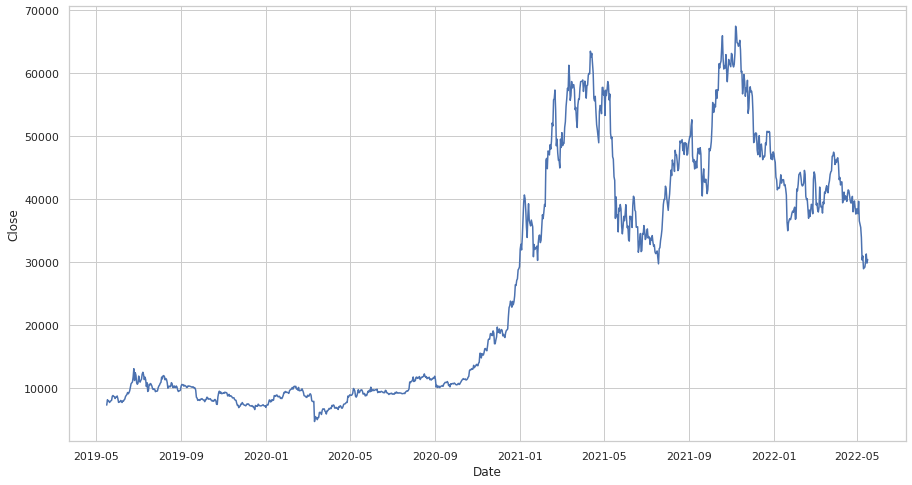

In [ ]:
#Visualize the data based on "closing price" (we want to predict this value)
plt.figure(figsize=(15,8))
sns.set_theme(style="whitegrid")
sns.lineplot(data=df,y="Close", x="Date")

In [ ]:
#find the mean and varience to see if distribution is non-stationary
print(df["Close"].describe())

count     1096.000000
mean     26445.350073
std      18757.517621
min       4724.390000
25%       9347.370000
50%      16520.625000
75%      42979.450000
max      67500.020000
Name: Close, dtype: float64


In [ ]:
# The data has splitted into two groups; %80 training (878 days) and %20 test (218 days)
split=pd.to_datetime("2021-10-10")
train_date= df["Date"]<=split
test_date= df["Date"]>split
df_train = df.loc[train_date]
df_test = df.loc[test_date]

display(df_train.head())
display(df_test.head())

,Date,Open,High,Low,Close
1095,2019-05-17,7393.58,7511.65,7295.38,7332.61
1094,2019-05-18,7328.42,8237.72,7328.42,8186.66
1093,2019-05-19,8172.97,8172.97,7715.42,8004.46
1092,2019-05-20,8004.58,8090.52,7864.92,7984.31
1091,2019-05-21,7965.94,8010.77,7731.16,7744.86


,Date,Open,High,Low,Close
217,2021-10-11,57399.23,57556.70,54375.79,56035.86
216,2021-10-12,56030.57,57686.24,54357.85,57357.61
215,2021-10-13,57385.89,58392.52,56931.28,57351.74
214,2021-10-14,57312.38,62563.02,56896.81,61526.33
213,2021-10-15,61698.03,62339.37,60217.26,60860.89


In [ ]:
#After we are certain that our data is ready to be fed, We don't need date column for the training.
df_train = df_train.drop(["Date"], axis=1).copy()

In [ ]:
#we normalize our data, in order to cope with outliers and noises. 
#Min-Max function put the values in a range of [0-1], as lowest value set up to be zero and the highest to be one.
scaler= MinMaxScaler()
df_train= scaler.fit_transform(df_train)

In [ ]:
#two list created to train the data
X_train, Y_train =[],[]

In [ ]:
#find the dimensions of data
#(rows,columns)
print(np.shape(df_train))

(878, 4)


In [ ]:
#for every prediction, the model will use past 60 values to predict next day
#X_train represents past values to train and Y_train represents how much the prediction close to the actual value.
for i in range(60, df_train.shape[0]):
  X_train.append(df_train[i-60:i])
  Y_train.append(df_train[i,0])


In [ ]:
#We turn them to numpy array so that Keras can accept it as input
X_train, Y_train = np.array(X_train), np.array(Y_train)
#Now, we have 818 rows, for each row we have 60 arrays and every one of them 4 diferent feature.
X_train.shape

(818, 60, 4)

In [ ]:
inputShape= X_train.shape[1]

In [ ]:
#Initialize the RNN
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
#[https://keras.io/guides/sequential_model/]
#
#We use Long Short-Term Memory layer - Hochreiter 1997.
#
#units--> dimensionality of output space.
#
#activation--> type of activation function to use. In LSTM, the functions is used in both Forget Gate and Output Gate
#Rectified linear activation function, ReLU, gives the values depending on whether the values have positive or negative sign.
#ReLU overcomes vanishing gradient problem, which was present in tanh function
#
#return_sequences--> whether to return the last output. in the output sequence, or the full sequence
#recurrent_activation--> is default sigmoid function. Plays role in every gate.
#
#input_shape--> declare our traning data's shape.
model = Sequential()
model.add(LSTM(units = 64, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))


In [ ]:
#Dropout is a regulation layer that randomly sets our input units to zero. 
#This behavior helps avoiding overfitting
#[https://keras.io/api/layers/regularization_layers/dropout/]
model.add(Dropout(0.2))
model.add(LSTM(units = 64, activation = 'relu', return_sequences = True))


In [ ]:
model.add(Dropout(0.3))
model.add(LSTM(units = 64, activation = 'relu', return_sequences = True))


In [ ]:
model.add(Dropout(0.4))
model.add(LSTM(units = 32, activation = 'relu'))

In [ ]:
#Dense layer set up for our output, which does not feed into our model.
model.add(Dense(units =1))

In [ ]:
#Adam is a modification for stochastic gradient descent.
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            17664     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_2 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                1

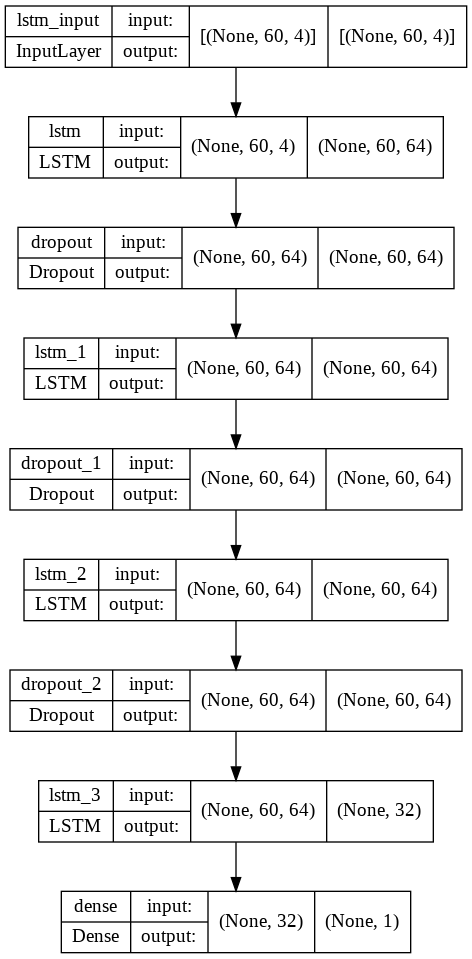

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#We can now train our model
#Epoch-->how many times an input iterate in the model
#Batch_size--> how much value will go as input
#epoch=!batch
#validation_split--> fraction of the training data to be used as validation data
history= model.fit(x=X_train, y=Y_train, epochs = 20, batch_size =60, validation_split=0.1)

Epoch 1/20
13/13 [==============================] - 23s 900ms/step - loss: 0.0839 - val_loss: 0.0197
Epoch 2/20
13/13 [==============================] - 5s 388ms/step - loss: 0.0202 - val_loss: 0.0169
Epoch 3/20
13/13 [==============================] - 5s 373ms/step - loss: 0.0111 - val_loss: 0.0134
Epoch 4/20
13/13 [==============================] - 5s 373ms/step - loss: 0.0081 - val_loss: 0.0228
Epoch 5/20
13/13 [==============================] - 5s 371ms/step - loss: 0.0056 - val_loss: 0.0173
Epoch 6/20
13/13 [==============================] - 5s 388ms/step - loss: 0.0046 - val_loss: 0.0134
Epoch 7/20
13/13 [==============================] - 5s 383ms/step - loss: 0.0045 - val_loss: 0.0130
Epoch 8/20
13/13 [==============================] - 5s 379ms/step - loss: 0.0046 - val_loss: 0.0116
Epoch 9/20
13/13 [==============================] - 5s 389ms/step - loss: 0.0044 - val_loss: 0.0105
Epoch 10/20
13/13 [==============================] - 5s 369ms/step - loss: 0.0044 - val_loss: 0.014

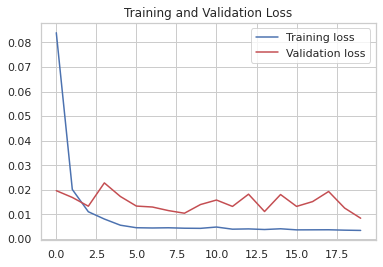

In [ ]:
#compare the loss between training and validation.
#The training loss indicates how well the model is fitting the training data,
#while the validation loss indicates how well the model fits new data
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
#After building model, we prepare for prediction
df_train_v2 = df.loc[train_date]
part_60_days = df_train_v2.tail(60)
df_set= part_60_days.append(df_test, ignore_index = True)
df_set.drop(['Date'], axis = 1, inplace=True)
df_set.head()

,Open,High,Low,Close
0,44399.98,47799.97,44259.27,47799.97
1,47794.49,48083.79,46151.36,47053.51
2,47056.98,47320.04,45608.97,47057.49
3,47056.27,47968.20,45669.48,45906.74
4,45942.60,47029.60,44569.56,44569.56


In [ ]:
input_set = scaler.transform(df_set)


In [ ]:
X_test = []
Y_test = []

for i in range (60, input_set.shape[0]):
    X_test = np.append(X_test, input_set[i-60:i])
    Y_test = np.append(Y_test, input_set[i, 0])
    

In [ ]:
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test.shape, Y_test.shape

((52320,), (218,))

In [ ]:
X_test = X_test.reshape((218, 60,4))


In [ ]:
#We start the prediction
Y_pred = model.predict(X_test)

In [ ]:
print('R2 Score: ', r2_score(Y_test, Y_pred))
print('MAE: ', mean_absolute_error(Y_test, Y_pred))

R2 Score:  0.6366580672379822
MAE:  0.07173912317521797


In [ ]:
#inverse transform manually
scaler.scale_
scale = 1/1.70226036e-05

Y_test = Y_test*scale
Y_pred = Y_pred*scale

In [ ]:
#reverse the sorting so that we can understand the direction of price
Y_pred=np.flip(Y_pred)
Y_test=np.flip(Y_test)

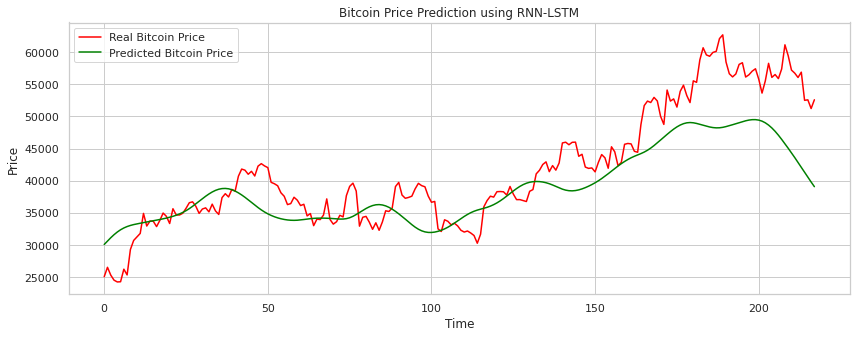

In [ ]:
#plot the prediction versus actual data
plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()